### Does the number of bits extracted from the embedding increase during training?

In [36]:
import pandas as pd 
import wandb

from tqdm.notebook import tqdm

api = wandb.Api()
entity, project = "jack-morris", "emb-inv-1"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

relevant_exp_names = ['mar17-baselines']
exp_runs = [run for run in runs if run.config.get('exp_group_name') in relevant_exp_names]

data = []
for run in tqdm(exp_runs):
    summary = {k: v for k,v in run.summary.items() if not k.startswith('gradients/')}
    obj = {**run.config, **summary}
    #
    h = run.scan_history(keys=["eval/perplexity"])
    ppl = [r["eval/perplexity"] for r in h]
    obj["ppl"] = ppl
    # 
    data.append(obj)

df = pd.DataFrame(data)
df = df[df["embedder_no_grad"]]
df = df.reset_index()
len(df)

  0%|          | 0/9 [00:00<?, ?it/s]

6

In [44]:
import math

df['eval/bits_per_token'] = df['eval/perplexity'].apply(math.log2)
df['eval/bits'] = df['eval/bits_per_token'] * (df['max_seq_length'] - 1)

In [37]:
df["ppl"]

0    [31.13918599082904, 28.52219331449862, 27.1088...
1    [42.11744665673833, 39.39937383662106, 37.8894...
2    [68.82594175435271, 64.92195299835761, 64.3134...
3    [3.2524468714436203, 2.2334248986550977, 1.943...
4    [21.807738856288466, 18.733303174960025, 17.29...
5    [13.49676963869839, 9.895715246263475, 8.84341...
Name: ppl, dtype: object

Text(0.5, 1.0, 'Bits recovered throughout training')

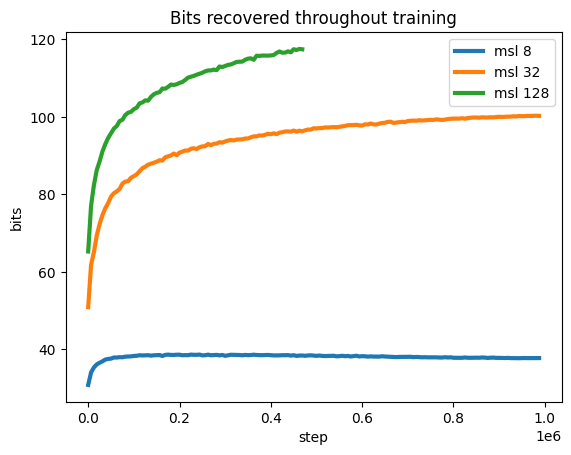

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ppl_diff(df):
    assert len(df) == 2
    ppl_unconditional = df[df["embedder_fake_with_zeros"]].iloc[0]["ppl"]
    ppl_conditional = df[~df["embedder_fake_with_zeros"]].iloc[0]["ppl"]
    # print(ppl_conditional)
    # print()
    #####
    msl = df["max_seq_length"].unique()[0]
    bits_unconditional = np.array([math.log2(p) * (msl-1) for p in ppl_unconditional])
    bits_conditional = np.array([math.log2(p) * (msl-1) for p in ppl_conditional])
    L = min(len(bits_unconditional), len(bits_conditional))
    bits_unconditional = bits_unconditional[:L]
    bits_conditional = bits_conditional[:L]
    #####
    assert len(bits_unconditional) == len(bits_conditional)
    bits_diff = bits_unconditional - bits_conditional
    xrange = [t * (10**6/160) for t in range(L)]
    sns.lineplot(x=xrange, y=bits_diff, label=f'msl {msl}', lw=3)
    


diff8 = plot_ppl_diff(df[df["max_seq_length"] == 8])
diff32 = plot_ppl_diff(df[df["max_seq_length"] == 32])
diff128 = plot_ppl_diff(df[df["max_seq_length"] == 128])

plt.xlabel('step')
plt.ylabel('bits')
plt.title('Bits recovered throughout training')